In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'leaf-rice-disease-indonesia:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1315070%2F2190457%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240409%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240409T210818Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D71564ea2973b043fbc95010e38d608e2bc9a18e0b6d1545afa3a123a5ae5c738a31417f22dd21c8e50e859c9094ad566c8ffab483a74e95adf164841667a8ab4a82bde572eeb67a9467dd85b1d5146532ff1304f5f2ad2adc1add09de45dc4ab66a852558e535fa2bb8f889f15e85f75be5878c5861f20c62278b0525b92dfbc084db7775a0e91a8f70c7884d00dcbf74217d6ce1c1d68df5e98d1ded870bb192ae125c01968e68091d129538d312ff3fb311d533b604fcedf1cd1f3b74fdbc788b550dd2279fdba4ca50a71519f89fa7472645d6245e5e432f81b6b73f7e3c62b6f18d842d053f01b0d34d2b1be44b01bd8e5c9c42151a0582316b4a9864806'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 22700941 bytes downloaded
Downloaded and uncompressed: leaf-rice-disease-indonesia
Data source import complete.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers,models
from keras.layers import Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model

from pathlib import Path
import os.path
import random
from collections import Counter

import matplotlib.cm as cm
import seaborn as sns
from cycler import cycler
import textwrap


from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot


BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

dataset = "/kaggle/input/leaf-rice-disease-indonesia"
walk_through_dir(dataset);

--2024-04-09 21:09:15--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-04-09 21:09:15 (19.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]

There are 3 directories and 0 images in '/kaggle/input/leaf-rice-disease-indonesia'.
There are 0 directories and 80 images in '/kaggle/input/leaf-rice-disease-indonesia/blast'.
There are 0 directories and 80 images in '/kaggle/input/leaf-rice-disease-indonesia/blight'.
There are 0 directories and 80 images in '/kaggle/input/leaf-rice-disease-indonesia/tungro'.


In [4]:
image_dir = Path(dataset)

filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

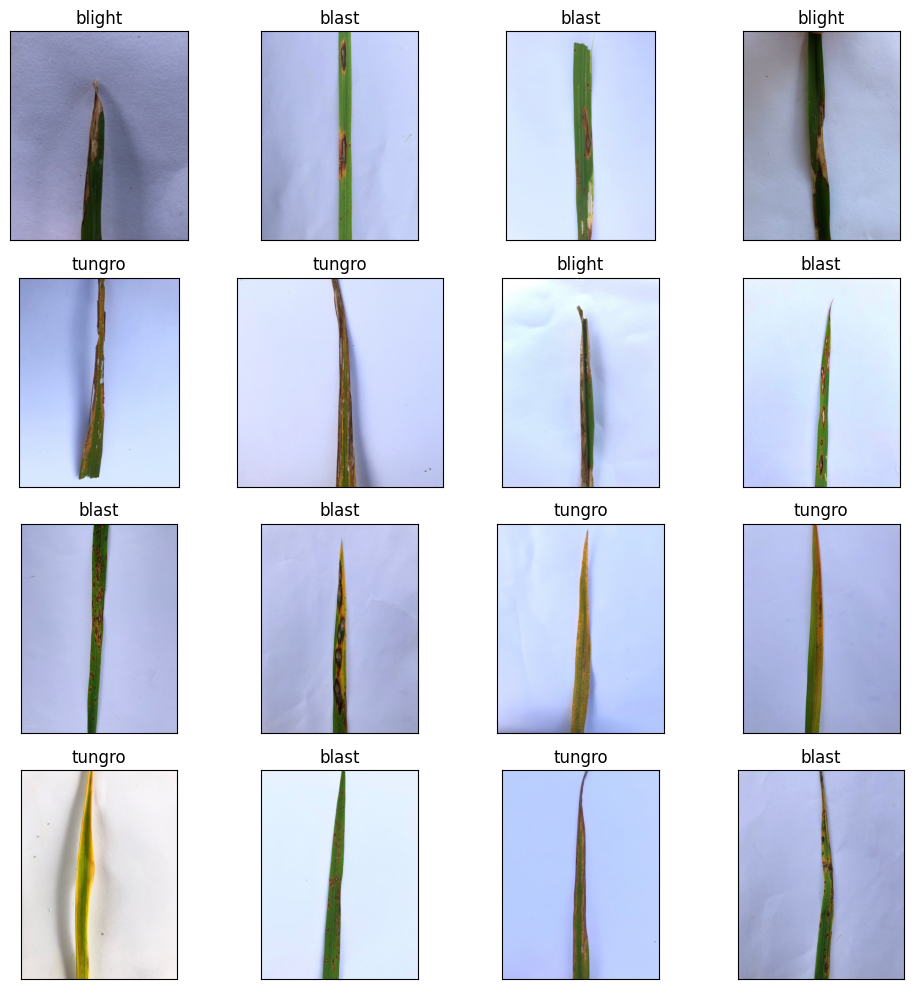

In [5]:
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [6]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [7]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [8]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 154 validated image filenames belonging to 3 classes.
Found 38 validated image filenames belonging to 3 classes.
Found 48 validated image filenames belonging to 3 classes.


In [9]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [10]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [12]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)


outputs = Dense(3, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
)

Epoch 1/100
5/5 [==============================] - 17s 1s/step - loss: 1.2039 - accuracy: 0.3701 - val_loss: 1.1431 - val_accuracy: 0.3421
Epoch 2/100
5/5 [==============================] - 3s 669ms/step - loss: 1.1709 - accuracy: 0.3701 - val_loss: 1.1296 - val_accuracy: 0.3421
Epoch 3/100
5/5 [==============================] - 4s 789ms/step - loss: 1.1414 - accuracy: 0.3766 - val_loss: 1.1170 - val_accuracy: 0.3684
Epoch 4/100
5/5 [==============================] - 3s 649ms/step - loss: 1.0993 - accuracy: 0.3831 - val_loss: 1.1036 - val_accuracy: 0.3684
Epoch 5/100
5/5 [==============================] - 4s 785ms/step - loss: 1.0923 - accuracy: 0.4091 - val_loss: 1.0910 - val_accuracy: 0.3684
Epoch 6/100
5/5 [==============================] - 3s 719ms/step - loss: 1.1304 - accuracy: 0.3961 - val_loss: 1.0784 - val_accuracy: 0.3947
Epoch 7/100
5/5 [==============================] - 3s 652ms/step - loss: 1.1633 - accuracy: 0.3117 - val_loss: 1.0672 - val_accuracy: 0.3947
Epoch 8/100
5/5